In [1]:
%matplotlib inline

import sys
PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)
from fma_metadata import utils

# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

import random
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

# Regression Libraries
import statsmodels.api as sm
from termcolor import colored as cl
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error




import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## A) Import and Merge Dataset

In [2]:
echonest = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/echonest.csv")
tracks = utils.load("/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/tracks.csv")

In [3]:
echo_genres = echonest['echonest','audio_features'].merge(tracks['track'][['genre_top']],on='track_id')
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


In [4]:
echo_genres['genre_top'].value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Country                   0
Easy Listening            0
Soul-RnB                  0
Spoken                    0
Name: genre_top, dtype: int64

In [9]:
echo_jazz = echo_genres[echo_genres['genre_top']=='Jazz']

## C) Linear Relationships
#### Echonest Correlations
Make a echonest sub-selection for each genre. In particular, we've selected genres that occours the most. For each echo_genre dataset we search some positive or negative linear relationship between echonest features.

#### Jazz

Text(0.5, 1, 'Correlation Matrix Echonest Jazz')

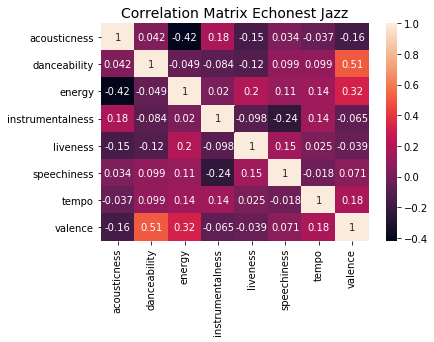

In [10]:
#Check Jazz correlation
sns.heatmap(echo_jazz.corr(),annot=True)
plt.title("Correlation Matrix Echonest Jazz", fontsize=14)

## D) Simple Linear Regression 
in this case we've one independent variable and a dependent variable

In [106]:
# echonest genre selected for regression
ECHO_GENRE = echo_jazz 
GENRE = 'Jazz'

# continuous dependent variable
DEP_VAR = 'danceability'

# continuous independent variable
INDEP_VAR_1 = 'valence'

#others continuous independent variables (MLR)'
INDEP_VAR_3 = 'speechiness'
INDEP_VAR_5 = 'tempo'

In [107]:
ECHO_GENRE.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz
237,0.968318,0.306269,0.541040,0.956206,0.088764,0.118233,130.996,0.039939,Jazz


### D.1) Best Linear Relationship
The best correlation we found is 0.61: between x=valence y=danceability in echonest old / historical genre.
P(danceability|valence). In general, we saw that for each genre danceability and valence are well correlated.

Text(0.5, 0, 'valence')

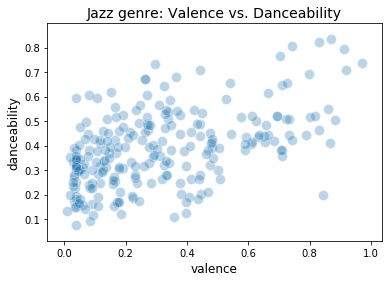

In [108]:
plt.scatter(y = DEP_VAR, x = INDEP_VAR_1, data = ECHO_GENRE, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title(GENRE+' genre: Valence vs. Danceability', fontsize = 14)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

## Removing outliers 

In [109]:
#isolation-forest sklearn version
F0 = IsolationForest(random_state=42, n_estimators=300, contamination=0.01).fit(ECHO_GENRE[[INDEP_VAR_1, DEP_VAR]]) 
    
# score isolation forest - sklearn
outliers_sk = F0.predict(ECHO_GENRE[[INDEP_VAR_1, DEP_VAR]])
    
# IsolationForest Sklearn
ECHO_GENRE['outlier_IF_sklearn'] = outliers_sk
ECHO_GENRE['outlier_IF_sklearn'] = ECHO_GENRE['outlier_IF_sklearn'].apply(lambda x: 'inlier' if x==1 else 'outlier')

In [110]:
print('number of outliers:',ECHO_GENRE[ECHO_GENRE['outlier_IF_sklearn'] == 'outlier'].shape[0])

number of outliers: 3


In [111]:
ECHO_GENRE_clean = ECHO_GENRE[ECHO_GENRE['outlier_IF_sklearn'] == 'inlier'].iloc[:,:9] # dataset without outliers
ECHO_GENRE.drop(columns='outlier_IF_sklearn', inplace=True) #removing outlier label from main dataset

## After removing 1% of outliers

Text(0.5, 0, 'valence')

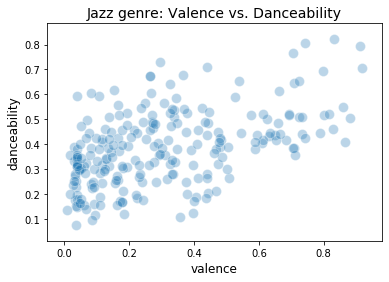

In [112]:
plt.scatter(y = DEP_VAR, x = INDEP_VAR_1, data = ECHO_GENRE_clean, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title(GENRE+' genre: Valence vs. Danceability', fontsize = 14)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

### D.2) Attributes
To build a Simple Linear Regression (SLR) model, we must have an independent variable and a dependent variable. For our SLR model, we are going to take Valence as the independent variable and Danceability as the dependent variable.

In [113]:
# independent variable
X_var = ECHO_GENRE_clean[[INDEP_VAR_1]]

#dependent variable
y_var = ECHO_GENRE_clean[[DEP_VAR]]

In [114]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### D.3) SLR model with Statsmodels
In this case we build a simple linear regression model which use statsmodel

In [115]:
# Ordinary Least Square
slr_model = sm.OLS(y_var,X_var)
slr_reg = slr_model.fit()

In [116]:
print( cl( slr_reg.summary(),attrs = ['bold']) )

                                 OLS Regression Results                                
Dep. Variable:           danceability   R-squared (uncentered):                   0.714
Model:                            OLS   Adj. R-squared (uncentered):              0.713
Method:                 Least Squares   F-statistic:                              591.0
Date:                Sun, 11 Apr 2021   Prob (F-statistic):                    2.54e-66
Time:                        19:58:10   Log-Likelihood:                          23.442
No. Observations:                 238   AIC:                                     -44.88
Df Residuals:                     237   BIC:                                     -41.41
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### D.4) SLR model with Scikit-learn

In [117]:
#Function to get cross validation score R2
def get_cv_scores(model,X_train,y_train):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=3,
                             scoring='r2')
    
    print('CV Mean (R2): ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [118]:
# build the model
slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X_test)

In [119]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.3122106469750829
STD:  0.17092121214834075


***Scores (no cv) on Test Data***
R2: 0.320
MSE: 0.017
MAE: 0.102


In [120]:
# Compute hypotesis weight and bias

# Y = wX+B where X=valence and Y=danceability
slr_slope = slr.coef_ # weight: w
slr_intercept = slr.intercept_ # bias B
print('Coefficients: \n', slr_slope)
print('Intercept: \n', slr_intercept)

Coefficients: 
 [[0.26752015]]
Intercept: 
 [0.30629223]


Text(0.5, 0, 'valence')

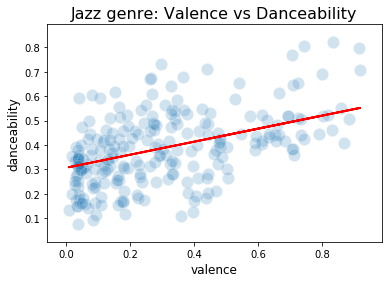

In [121]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE_clean , s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE_clean[INDEP_VAR_1], slr_slope*ECHO_GENRE_clean[[INDEP_VAR_1]] + slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)

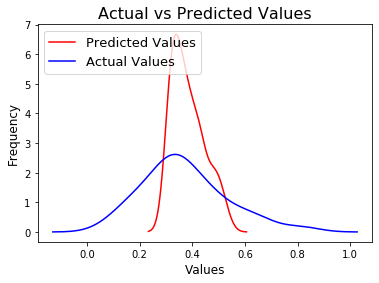

In [122]:
# I valori compresi tra 0.3 e 0.55 vengono predetti più volte di quanto realmente appaiono nella distribuzione.

# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### D.5) Lasso Simple Linear Regression (L1 Regularization) 

In [123]:
alpha = [random.uniform(1e-6,1) for x in range(10000)]
param_grid = dict(alpha=alpha)

In [124]:
lasso_slr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_slr, param_distributions=param_grid, n_iter=500, cv = 3, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   11.8s finished


In [125]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.10993331383230383
Best Params:  {'alpha': 0.003938815469978952}


#### Retrain the lasso regression with optimal value of alpha

In [126]:
lasso_slr = Lasso(alpha=0.003938815469978952)
lasso_slr.fit(X,y)
y_pred = lasso_slr.predict(X_test)

In [127]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.30469909209618673
STD:  0.13380484322750658


***Scores (no cv) on Test Data***
R2: 0.262
MSE: 0.019
MAE: 0.106


In [128]:
lasso_slr_slope = lasso_slr.coef_ 
lasso_slr_intercept = lasso_slr.intercept_ 
print('Coefficients: \n', lasso_slr.coef_)
print('Intercept: \n', lasso_slr.intercept_)

Coefficients: 
 [0.19853007]
Intercept: 
 [0.32712091]


Text(0.5, 0, 'valence')

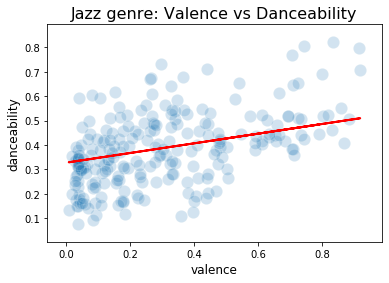

In [129]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE_clean, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE_clean[INDEP_VAR_1], lasso_slr_slope*ECHO_GENRE_clean[[INDEP_VAR_1]] + lasso_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


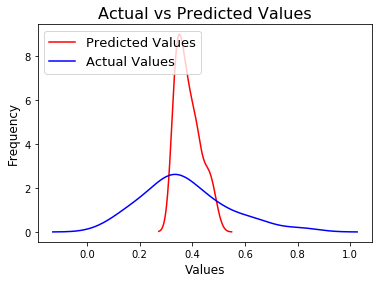

In [130]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### D.6) Ridge Simple Linear Regression (L2 Regularization)

In [131]:
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [132]:
ridge_slr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_slr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:   12.8s finished


In [133]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.16406911932843682
Best Params:  {'alpha': 0.2928785336961518}


#### Retrain ridge regression with optimal value of alpha

In [134]:
ridge_slr = Ridge(alpha=0.2928785336961518)
ridge_slr.fit(X,y)
y_pred = ridge_slr.predict(X_test)

In [135]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_slr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.3138833173806022
STD:  0.14819347408947323


***Scores (no cv) on Test Data***
R2: 0.314
MSE: 0.017
MAE: 0.102


In [136]:
ridge_slr_slope = ridge_slr.coef_ 
ridge_slr_intercept = ridge_slr.intercept_
print('Coefficients: \n', ridge_slr.coef_)
print('Intercept: \n', ridge_slr.intercept_)

Coefficients: 
 [[0.2595008]]
Intercept: 
 [0.30871334]


Text(0.5, 0, 'valence')

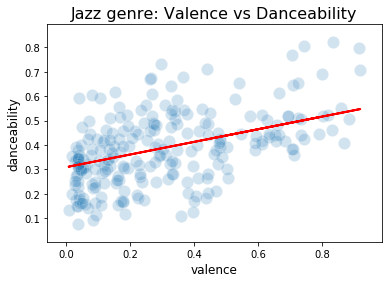

In [137]:
# plot the regression function
sns.scatterplot(x = INDEP_VAR_1, y = DEP_VAR, data = ECHO_GENRE_clean, s = 150, alpha = 0.2, edgecolor = 'white')
plt.plot(ECHO_GENRE_clean[INDEP_VAR_1], ridge_slr_slope*ECHO_GENRE_clean[[INDEP_VAR_1]] + ridge_slr_intercept, color = 'r', linewidth = 2)
plt.title(GENRE+' genre: Valence vs Danceability', fontsize = 16)
plt.ylabel(DEP_VAR, fontsize = 12)
plt.xlabel(INDEP_VAR_1, fontsize = 12)


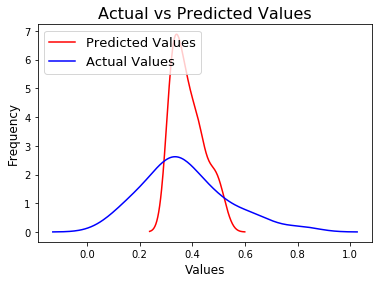

In [138]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

## E) Multivariate Linear Regression: MLR
In this case we have more than one independent variable and a dependent variable. 

### E.1) Attributes
To build a Multivariate Linear Regression (MLR) model, we selected two indipendents variables which the higher correlation with danceability (always in historical genre). Its are Energy and Valence, rispectivetly 0.32 and 0.62.

In [141]:
# independent variables
X_var = ECHO_GENRE[[INDEP_VAR_1,INDEP_VAR_3,INDEP_VAR_5]]     # tempo , valence, speechiness

#dependent variable
y_var = ECHO_GENRE[[DEP_VAR]] #danceability

Tempo has a different range values. We need to normalize the data

In [142]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_var = scaler.fit_transform(X_var)
y_var = scaler.fit_transform(y_var)

In [143]:
# split data in development and internal test
X, X_test, y, y_test = train_test_split(X_var, y_var, test_size=0.30 ,random_state=0)

### E.2) MLR simple model

In [144]:
# build the model (same as before)
mlr = LinearRegression()
mlr.fit(X,y)
y_pred = mlr.predict(X_test)

In [145]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.13430714278853093
STD:  0.09105459969558832


***Scores (no cv) on Test Data***
R2: 0.257
MSE: 0.730
MAE: 0.676


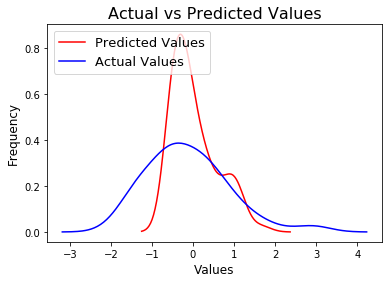

In [146]:
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.3) Lasso MLR model: (L1 Regularization)
##### Evaluation with alpha optimization
We've used GridSearch to find the optimal alpha value

In [147]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1e-1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [148]:
lasso_mlr = Lasso()
grid = RandomizedSearchCV(estimator=lasso_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    5.0s finished


In [149]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.21319874284776857
Best Params:  {'alpha': 0.01567313061208199}


#### Retrain lasso MLR with optimal value of alpha

In [150]:
lasso_mlr = Lasso(alpha=0.01567313061208199)
lasso_mlr.fit(X,y)
y_pred = lasso_mlr.predict(X_test)

In [151]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(lasso_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.13918656478356603
STD:  0.08478368017344659


***Scores (no cv) on Test Data***
R2: 0.261
MSE: 0.726
MAE: 0.673


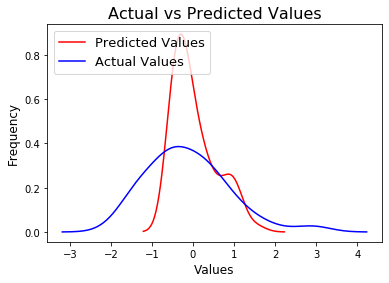

In [152]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)

### E.4) Ridge MLR model: (L2 Regularization)
#### E.4.1) Evaluation with alpha optimization
We've used GridSearch to find the optimal alpha value

In [153]:
# find optimal alpha with grid search
alpha = [random.uniform(1e-6,1) for x in range(100000)]
param_grid = dict(alpha=alpha)

In [154]:
ridge_mlr = Ridge()
grid = RandomizedSearchCV(estimator=ridge_mlr, param_distributions=param_grid, n_iter=500, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X, y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    2.4s finished


In [155]:
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Best Score:  0.2122351017285736
Best Params:  {'alpha': 0.993073783445319}


#### Retrain ridge MLR with optimal value of alpha

In [156]:
ridge_mlr = Ridge(alpha=0.993073783445319)
ridge_mlr.fit(X,y)
y_pred = ridge_mlr.predict(X_test)

In [157]:
#Evaluations
print("***Cross Validation R2 score - Test Data***")
get_cv_scores(ridge_mlr,X_test,y_test) #R2 cv on training data

print("***Scores (no cv) on Test Data***")
print('R2: %.3f' % r2_score(y_test, y_pred))
print('MSE: %.3f' % mean_squared_error(y_test, y_pred))
print('MAE: %.3f' % mean_absolute_error(y_test, y_pred))

***Cross Validation R2 score - Test Data***
CV Mean (R2):  0.13685244352857448
STD:  0.0855878150774653


***Scores (no cv) on Test Data***
R2: 0.257
MSE: 0.730
MAE: 0.675


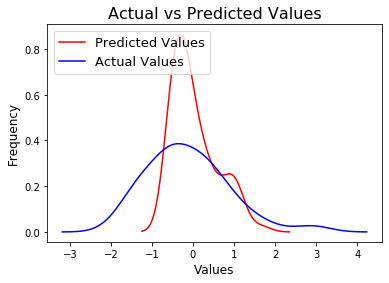

In [158]:
# Plot frequency of predicted and actual values
sns.distplot(y_pred, hist = False, color = 'r', label = 'Predicted Values')
sns.distplot(y_test, hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)